# Simulation_CLP_PID_FF

### Simulation of a PID in closed loop with feed forward option

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import package_DBR
from package_DBR import myRound, SelectPath_RT, FO_RT, Delay_RT

import package_LAB
from package_LAB import LEADLAG_RT, PID_RT
package_LAB = reload(package_LAB)

## Simulation parameters

In [8]:
TSim = 2200
Ts = 1
N = int(TSim/Ts) + 1

# Working points
MV0 = 50
DV0 = 50
PV0 = 75    #To determine experimentally (set MV and DV at 50% and read stabilized PV value)

# Input/output simulation parameters
Kp = 0.5310660848084217
T1p = 186.994025442462
T2p = 2.9068218394939005e-05
thetap = 2.999961859860621

# Disturbance simulation parameters
Kd = 0.6100735687252915
T1d = 260.50316881553425
T2d = 10.615160143180168
thetad = 1.1476745182375387

# PID parameters
gamma = 0.6
Kc = 1.9
Ti = 110.0
Td = 10.0
# Kc, Ti, Td = IMCTuning(Kp,T1p,T2p,thetap,gamma,'SQPDT')

alpha = 1
MVmin = 0
MVmax = 100

## Simulation scenarios

In [9]:
##### SCENARIO 1 : Closed Loop without feedforward
man_modePath = {0: True, 750: False, TSim: False}
MVManPath = {0: MV0, TSim: MV0}
SPpath = {0: PV0, 800: PV0 - 10, TSim: PV0 - 10}
DVPath = {0: DV0, 1500: DV0+10, TSim: DV0 + 10}
FF_Active = False

## Simulation variables

In [10]:
t = []
SP = []
E = []
MV = []
MVP = []
MVI = []
MVD = []
MVFF = []
man_mode = []
MVMan = []
MVmin = 0
MVmax = 100
DV = []
PV = []
Kc = 1.3
Ti = 9
Td = 7
alpha = 0.5

# for P(s)
MVDelayp = []
PV1p = []
PV2p = []

# for D(s)
MVDelayd = []
PV1d = []
PV2d = []


## Simulation

In [11]:
for i in range(0,N):
    t.append(i*Ts)

    # Setpoint and Disturbance value
    SelectPath_RT(SPpath, t, SP)
    SelectPath_RT(DVPath, t, DV)

    # manual data
    SelectPath_RT(man_modePath, t, man_mode)
    SelectPath_RT(MVManPath, t, MVMan)

    # PID
    PID_RT(SP, E, MV, MVP, MVI, MVD, man_mode, MVMan, MVmin, MVmax, PV, Ts, Kc ,Ti, Td, alpha)

    # P(s)
    # reminder : Delay_RT(MV,theta,Ts,MV_Delay,MVInit=0)
    Delay_RT(MV, thetap, Ts, MVDelayp, MV0)
    FO_RT(MVDelayp, Kp, T1d, Ts, PV1p, 0)
    FO_RT(PV1p, 1, T2p, Ts, PV2p, 0)

    # D(s)
    Delay_RT(DV - DV0 * np.ones_like(DV), thetad, Ts, MVDelayd, 0)
    FO_RT(MVDelayd, Kd, T1d, Ts, PV1d, 0)
    FO_RT(PV1d, 1, T2d, Ts, PV2d, 0)

    PV.append(PV2p[-1] + PV2d[-1] + PV0-Kp*MV0)

## plots

(0.0, 2200.0)

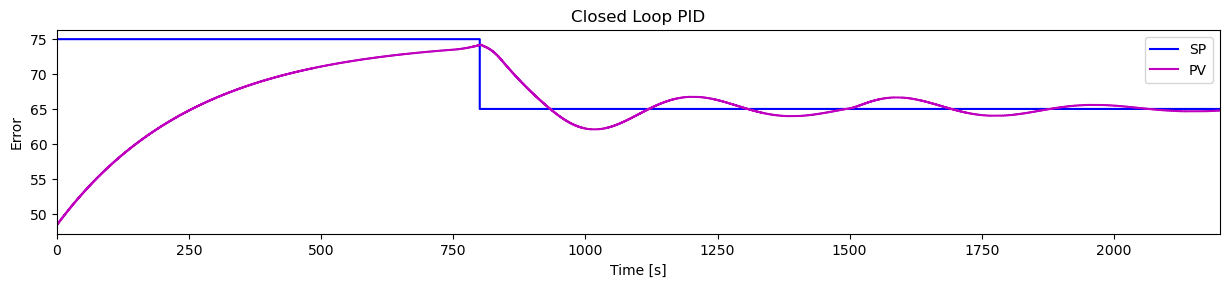

In [13]:
plt.figure(figsize = (15,9))

plt.subplot(3,1,1)
plt.title('Closed Loop PID')
plt.step(t,SP,'b-',label='SP',where='post')
plt.step(t,PV,'m-',label='PV',where='post')
plt.ylabel('Error')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.xlim([0, TSim])